# Ice rink user group analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from collections import Counter

In [2]:
data = "data/2025-07-25.csv"

## Clean up column names so don't have to deal with spaces

In [3]:
df = pd.read_csv(data)

In [4]:
df.rename(
    columns={
        "Timestamp": "timestamp",
        "Which club(s) are you a member of at the Oxford Ice Rink? ": "club",
        "Which sports/activities do you primarily participate in at the rink?  ": "activity",
        "Do you use the Oxford Ice Rink for leisure or for a club/organised activity?  ": "use_type",
        "How frequently do you use the Oxford Ice Rink?  ": "frequency",
        "What is the first half of your postcode (e.g., OX1, OX2, OX3)? (This helps us understand geographical impact without identifying you. If you don't know, please provide the nearest major postcode.)  ": "postcode",
        "What is your age group?  ": "age_group",
        "Do you have any special needs or requirements that affect your travel to the rink (e.g., Blue Badge holder, mobility issues)?": "special_needs",
        "How do you currently travel to the Oxford Ice Rink?": "travel_mode",
        "If you currently travel by car, approximately how much do you typically spend on car parking per visit to the Oxford Ice Rink area?  ": "car_parking_cost",
        "The proposed congestion charge is £5 per journey into and out of the city. How would this additional £5 charge impact your ability or willingness to travel to the Oxford Ice Rink by car?  ": "congestion_charge_impact",
        "Are you aware of any alternative means or options for travel to the Oxford Ice Rink that you could use if a congestion charge were implemented (e.g., park and ride, bus routes, cycling routes)?  ": "alternative_travel_options",
        "Please provide any additional comments or concerns you have regarding the proposed congestion charge and its potential impact on your use of the Oxford Ice Rink.  ": "congestion_charge_comments",
        "Do you consider than the daily congestion charge might stop you from partaking in your club activity? Y or N or n/a": "congestion_charge_stop_club_activity",
        "Would you like us to keep in touch with you to update you of the progress of this survey? If so and you are over the age of 18, please leave your email address here: ": "email",
    },
    inplace=True,
)
df.head()

,timestamp,club,activity,use_type,frequency,postcode,age_group,special_needs,travel_mode,car_parking_cost,congestion_charge_impact,alternative_travel_options,congestion_charge_comments,congestion_charge_stop_club_activity,email
0,25/06/2025 08:48:33,Oxford Rising Stars (Ice Hockey),"Ice Hockey, Public Skating Sessions",Both,Once a week,OX14,45-54,No,Car (as driver),£1 - £5,"Significant negative impact (e.g., would stop ...",Yes,NaN,Yes,NaN
1,25/06/2025 09:32:54,Oxford Rising Stars (Ice Hockey),Ice Hockey,"Club/Organised Activity (e.g., team practice, ...",2-3 times a week,OX14,45-54,No,Car (as driver),£6 - £10,"Significant negative impact (e.g., would stop ...",Yes,I am aware of alternative routes into the ice ...,Yes,NaN
2,02/07/2025 09:06:11,"Oxford Junior Stars (Ice Hockey), Oxford Midni...","Ice Hockey, Public Skating Sessions",Both,2-3 times a week,OX18,Under 16,No,Car (as passenger),"£0 (e.g., drop-off/pick-up only, free parking)","Significant negative impact (e.g., would stop ...",Yes,Cannot use public transport due to big hockey ...,Yes,NaN
3,02/07/2025 09:07:41,Oxford Junior Stars (Ice Hockey),Ice Hockey,"Club/Organised Activity (e.g., team practice, ...",2-3 times a week,OX16,Under 16,No,Car (as passenger),£1 - £5,"Significant negative impact (e.g., would stop ...",Yes,ice hockey bags are huge and not practical to ...,Yes,NaN
4,02/07/2025 09:08:03,"Oxford Junior Stars (Ice Hockey), Oxford 84's,...",Ice Hockey,Both,2-3 times a week,OX33,Under 16,No,Car (as driver),£6 - £10,"Significant negative impact (e.g., would stop ...",Yes,"We can't use the bus, we are a family of 5 wit...",Yes,Yes


## Get info on club membership

In [5]:
def split_multilabel(text):
    """Split text with mutliple labels on common separators and clean up"""
    if pd.isna(text):
        return []
    
    # Split on common separators: comma, semicolon, 'and', plus sign
    labels = re.split(r'[,;+]|\band\b', str(text))
    
    # Clean up each club name
    cleaned_labels = []
    for club in labels:
        club = club.strip()
        if club and club.lower() not in ['', 'n/a', 'none']:
            cleaned_labels.append(club)
    
    return cleaned_labels

In [16]:
# Split out individual clubs and count frequencies

club_type = {
"Oxford Junior Stars": "Ice Hockey",
"Fans/Spectators": "None",
"Figure Club": "Figure Skating",
"Other": "None",
"Oxford Rising Stars": "Ice Hockey",
"OXIST (Oxford Ice Skating Club)": "Figure Skating",
"I am not a member of any club.": "None",
"Junior Dance Club": "Dance",
"Oxford Midnight Stars": "Ice Hockey",
"RAF Blue Wings": "Ice Hockey",
"Oxford 84's": "Ice Hockey",
"Oxford City Stars": "Ice Hockey",
"Oxford Shooting Stars": "Ice Hockey",
"Oxford University Ice Hockey Club": "Ice Hockey"
}

def clean_club_name(club_name):
    """Remove the part in parentheses from the club name.
    >>> clean_club_name("Oxford Junior Stars (Ice Hockey)")
    'Oxford Junior Stars'
    """
    # Remove the part in parentheses and strip whitespace
    cleaned_name = re.sub(r'\s*\(.*?\)', '', club_name).strip()
    return cleaned_name

# Create a list of all individual club memberships
all_clubs = []
for club_text in df['club']:
    individual_clubs = split_multilabel(club_text)
    all_clubs.extend(individual_clubs)
all_clubs = [clean_club_name(club) for club in all_clubs]

individual_club_counts = Counter(all_clubs)

# Create a dataframe for easier analysis
club_freq_df = pd.DataFrame(list(individual_club_counts.items()), 
                           columns=['Club', 'Frequency']).sort_values('Frequency', ascending=False)
club_freq_df['Club Type'] = club_freq_df['Club'].map(club_type).fillna("None")            
club_freq_df['Percentage'] = round(100 * (club_freq_df['Frequency'] / sum(club_freq_df['Frequency'])), 1)

club_freq_df.reset_index(drop=True, inplace=True)
print(club_freq_df)

                                 Club  Frequency       Club Type  Percentage
0                 Oxford Junior Stars         72      Ice Hockey        24.1
1                     Fans/Spectators         39            None        13.0
2                         Figure Club         33  Figure Skating        11.0
3                               Other         32            None        10.7
4                 Oxford Rising Stars         29      Ice Hockey         9.7
5                               OXIST         24            None         8.0
6      I am not a member of any club.         24            None         8.0
7                   Junior Dance Club         11           Dance         3.7
8               Oxford Midnight Stars         10      Ice Hockey         3.3
9                      RAF Blue Wings          9      Ice Hockey         3.0
10                        Oxford 84's          5      Ice Hockey         1.7
11                  Oxford City Stars          5      Ice Hockey         1.7

In [17]:
# Get frequency by club type
club_type_counts = club_freq_df.groupby('Club Type')['Frequency'].sum().reset_index()
club_type_counts['Percentage'] = round((club_type_counts['Frequency'] / sum(club_freq_df['Frequency'])) * 100, 1)

print(club_type_counts)

        Club Type  Frequency  Percentage
0           Dance         11         3.7
1  Figure Skating         33        11.0
2      Ice Hockey        136        45.5
3            None        119        39.8


## Get info on activities

In [29]:
# Create a list of all use_types
all_use_types = []
for text in df['use_type']:
    individual_activities = split_multilabel(text)
    all_use_types.extend(individual_activities)


individual_use_type_counts = Counter(all_use_types)
use_type_freq_df = pd.DataFrame(list(individual_use_type_counts.items()), 
                           columns=['Use Type', 'Frequency']).sort_values('Frequency', ascending=False)
use_type_freq_df.reset_index(drop=True, inplace=True)
print(use_type_freq_df)

                        Use Type  Frequency
0                           Both        115
1  Club/Organised Activity (e.g.         67
2                  team practice         67
3           competitive lessons)         67
4                  Leisure (e.g.         24
5                 public skating         24
6          recreational lessons)         24


## Get info on use type (club vs public)

In [ ]:
# This is not multilabel 
df['use_type'].value_counts()

use_type
Both                                                                  115
Club/Organised Activity (e.g., team practice, competitive lessons)     67
Leisure (e.g., public skating, recreational lessons)                   24
Name: count, dtype: int64

## Get info on frequency

In [34]:
# this isn't multilabel either
df['frequency'].value_counts()

frequency
2-3 times a week          109
4-6 times a week           40
Once a week                36
Daily                       9
Less than once a month      8
2-3 times a month           4
Once a month                1
Name: count, dtype: int64

In [52]:
def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap()(np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(
            labels, widths, left=starts, height=0.5, label=colname, color=color
        )

        r, g, b, _ = color
        text_color = "white" if r * g * b < 0.5 else "darkgrey"
        ax.bar_label(rects, label_type="center", color=text_color, fmt="%.0f%%")
    # ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1), loc="lower left", fontsize="small")
    ax.legend(
        ncol=len(category_names),
        bbox_to_anchor=(0, -0.1),
        loc="lower left",
        fontsize="small",
    )

    return fig, ax

In [54]:
custom_order = [
    "Daily",
    "4-6 times a week", 
    "2-3 times a week",
    "Once a week",
    "2-3 times a month",
    "Once a month",
    "Less than once a month"
]

freq_results = {
    "All": df["frequency"]
    .value_counts(dropna=True, normalize=True)
    .reindex(custom_order)  # Reorder according to custom_order
    .tolist()
}
freq_results = {k: list(map(lambda x: x * 100, v)) for k, v in freq_results.items()}
freq_results

{'All': [4.3478260869565215,
  19.32367149758454,
  52.65700483091788,
  17.391304347826086,
  1.932367149758454,
  0.4830917874396135,
  3.864734299516908]}

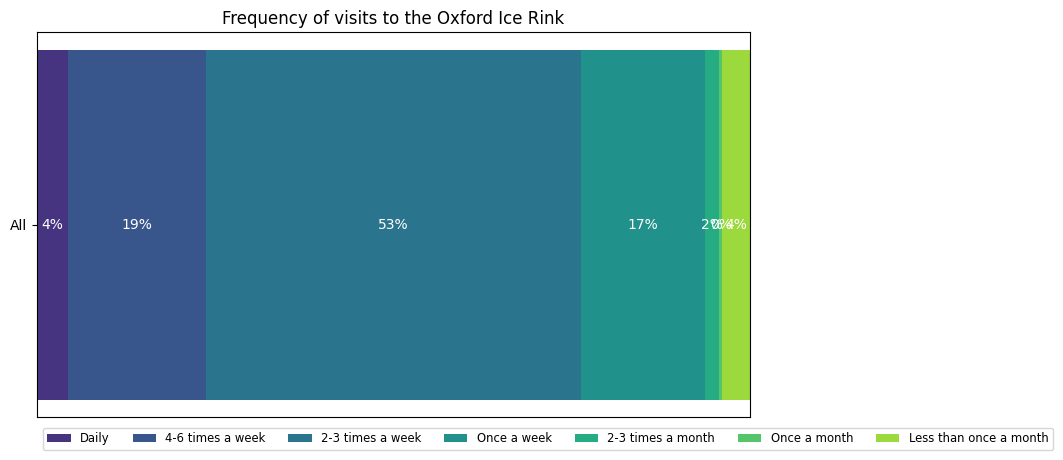

In [55]:
survey(freq_results, custom_order)
plt.title("Frequency of visits to the Oxford Ice Rink")
plt.show()

## Plot the postcodes where people live

In [58]:
df['postcode'].value_counts()

# Make a table of the postcodes
postcode_counts = df['postcode'].value_counts().reset_index()
postcode_counts.columns = ['postcode', 'count']

postcode_counts

,postcode,count
0,OX14,12
1,OX2,9
2,OX11,9
3,OX3,8
4,OX12,7
...,...,...
82,RG22,1
83,Ox9,1
84,RG8,1
85,Cv32,1


In [59]:
import pgeocode

nomi = pgeocode.Nominatim('gb')

def get_lat_long(postcode):
    """Get latitude and longitude for a given postcode."""
    location = nomi.query_postal_code(postcode)
    if location is not None:
        return location.latitude, location.longitude
    else:
        return None, None

In [60]:
postcode_counts['latitude'], postcode_counts['longitude'] = zip(*postcode_counts['postcode'].apply(get_lat_long))

In [61]:
postcode_counts

,postcode,count,latitude,longitude
0,OX14,12,51.648575,-1.255983
1,OX2,9,51.762770,-1.287940
2,OX11,9,51.587217,-1.235517
3,OX3,8,51.780400,-1.217167
4,OX12,7,51.593492,-1.430721
...,...,...,...,...
82,RG22,1,51.248700,-1.124400
83,Ox9,1,51.726043,-0.981030
84,RG8,1,51.505683,-1.110456
85,Cv32,1,52.303333,-1.523167


In [89]:
import plotly.express as px

ICE_RINK = (51.7488, -1.2650)

fig = px.scatter_map(
    postcode_counts,
    lat="latitude",
    lon="longitude",
    size="count",
    opacity=0.8,
    zoom=8,
    height=1200,
    width=1400,
)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.update_layout(
    coloraxis_colorbar=dict(title="Coverage", tickformat=".0%"),
)
fig.update_layout(
    coloraxis=dict(cmin=0.0, cmax=0.9),
)
fig.add_scattermap(
    lat=[ICE_RINK[0]],
    lon=[ICE_RINK[1]],
    mode='markers',
    marker=dict(
        size=15,
        opacity=0.8,
        symbol='star',
    ),
)


fig.show()

In [71]:
postcode_counts.head()

,postcode,count,latitude,longitude
0,OX14,12,51.648575,-1.255983
1,OX2,9,51.762770,-1.287940
2,OX11,9,51.587217,-1.235517
3,OX3,8,51.780400,-1.217167
4,OX12,7,51.593492,-1.430721


In [56]:
import pgeocode

nomi = pgeocode.Nominatim('gb')
nomi.query_postal_code("ox4")

postal_code                                                  OX4
country_code                                                  GB
place_name        Littlemore, Iffley, Cowley, Sandford-on-Thames
state_name                                               England
state_code                                                   ENG
county_name                                          Oxfordshire
county_code                                             11609045
community_name                                              None
community_code                                              None
latitude                                               51.723725
longitude                                              -1.224375
accuracy                                                     4.0
Name: 0, dtype: object